This notebook fits transmittance vs tangent altitude and evaluates the inverse Abel integral equation to determine pseudo-density. We will use the following definitions for transmittance $T$ as a function of tangent altitude $h$ and radial altitude $r$:

$$T(h, E) = \text{exp} \left(-\Gamma(h, E) \right)$$ and $$T(r, E) = \text{exp} \left( -\int \gamma(r, E) ds \right)$$.

Tangent altitude is $h$, radius to the tangent point is $y=h+y_{0,ref}$ where $y_{0,ref} = \max(R_{planet})+h_{0,ref}$ ($h_{0,ref} \sim 40$km). is the radius of the reference sphere used for navigation. The radial geocentric distance is $r$ and $s$ spans the telescopic line of sight. Optical depth is $\Gamma$ and "atmospheric depth" or "pseudo-density" is $\gamma(r, E)=\sigma(E) n(r)$ (pseudo-density). This is similar to the convention that column density is $N(h)$ and number density is $n(r)$ used by Roble and Hays (https://www.sciencedirect.com/science/article/abs/pii/0032063372901948), but I am not defining cross section. I decided to do this because it decouples the atomic physics and the navigational problem and it will probably make post-processing for atmospheric science easier.

For the purpouse of navigation, we fit $T(h)$ to the data, then we reconstruct the "smooth model" (this replaces the transmission model previouslt calculated by integrating the telescope's LOS), but in order to actually get a useful measurement, we replace h_50 with the filter's estimation.

In order to analyze the atmosphere and make use of the spherically-stratified assumption, the first step is to convert $h$ into $y=y_{0,ref}+h$. In a spherically-straified atmosphere where the satelite is at $s=\infty$, we can determine optical depth by integrating pseudo-density along the line of sight:

$$\Gamma(y) = 2 \int_y^\infty \gamma (r) ds$$ where $y^2+s^2=r^2$. Therefore, we can derive the version of the Abel integral that is used in density retrieval: $$\Gamma(y) = 2 \int_y^\infty \frac{\gamma(r)r}{\sqrt{r^2-y^2}}dr$$ The inverse Abel integral can be derived with Laplace transforms, and is given by 

$$\gamma(r) = -\frac{1}{\pi} \int_r^{\infty} \frac{\frac{\text{d}\Gamma(y)}{\text{d}y}}{\sqrt{y^2-r^2}}\text{d}y$$ This is the equation that must be solved when measuring atmospheric density. For a given energy band, $\sigma(E)$ is a constant that can be defined as the center of the energy band (or slightly differently based on the source spectrum), and the density can be determined by $n(r)=\gamma(r)/\sigma(E)$.

In [29]:
# Build the integrand. With the change of variables h=z/(1-z)+r, we can integrate wrt z = [0, 1]
import sympy as sp
y, f, z, r, N, D, I = sp.symbols("y f z r N D I", real=True)   # used in the Abel transform, N is the numerator, D is denominator, I is integrand
a, b, c, d = sp.symbols("a b c d", real=True)  # fit parameters
y=(z/(1-z))+r   # Either keep or highlight this 
N = -a*𝑏/(a*sp.sinh(b*(y-c)) + d*sp.cosh(b*(y-c)))  # Numerator. Alternate form: 2 b csch(2 b (c - h))
D = sp.sqrt(y**2-r**2)    # Denominator
I = (-1/sp.pi)*(N/D)/(1-z**2)
I

a*b/(pi*(1 - z**2)*sqrt(-r**2 + (r + z/(1 - z))**2)*(a*sinh(b*(-c + r + z/(1 - z))) + d*cosh(b*(-c + r + z/(1 - z)))))

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

R_planet = 6368.16   # km, radius of Earth at tangent point (this is like 'y_0,ref' above)

## It is important to note that the data being readd into this file uses an ellipsoid Earth,
## so we're not looking for exact constistency... just order of magnitude.

timeTransmit = np.load("timeTransmit.npy")
time_data = timeTransmit[:,0]
transmit_data = timeTransmit[:,1]
timeAlt = np.load("timeAlt.npy")
time_crossing_model = timeAlt[:,0]
y_list = timeAlt[:,1]+R_planet  # Note that this would be "y" in my new notation

crossing_range = np.where((time_data>=time_crossing_model[0])&(time_data<=time_crossing_model[-1]))[0]
time_data = time_data[crossing_range]
transmit_data = transmit_data[crossing_range]

# 1) Since the transmit data doesnt correspond to time_crossing_model, we first need to interpolate h_list
# We can avoid this is the future by by definining time_crossing_model differently in another script so that instead of t0_model+[0:175:1], it is t0_model+[dt1:175+dt1:1] where dt1 = time_data[0] - t0_model... but the interpolation is fine for this example
y_vs_time = interp1d(time_crossing_model, y_list, "cubic")
time_vs_y = interp1d(y_list, time_crossing_model, "cubic")
y_data = y_vs_time(time_data)

In [31]:
w1 = np.where(transmit_data>=0.01)[0][0]  # can't go to zero
w2 = np.where(transmit_data >= 0.99)[0][0]  # could also use -1

transmit_measured = transmit_data[w1:w2]
y_measured = y_data[w1:w2]
Gamma_measured = -np.log(transmit_measured)

# tanh() fit on transmittance:

130.08709185603038

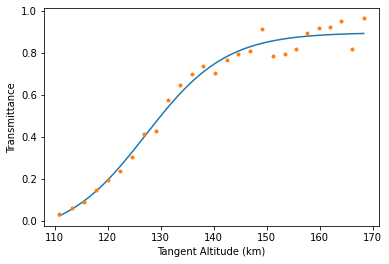

In [41]:
h50_error = 80
# we can fit to either y or h, the c parameter is the only thing that will change
def transmit_vs_y(y, a, b, c, d):
    return a*np.tanh(b*(y-c))+d

a_guess = 0.5
b_guess = 1/50    # we need to know how much tangent altitude is spanned from 1% to 99%
d_guess = 0.5
c_guess = (R_planet+100) - np.arctanh((0.5-d_guess)/a_guess)/b_guess + h50_error # 6496 is our best guess for y50
popt, pcov = curve_fit(transmit_vs_y, y_measured, transmit_measured, p0=[a_guess, b_guess, c_guess, d_guess])
a, b, c, d = popt

y = np.linspace(np.min(y_measured), np.max(y_measured), 1000)
plt.plot(y-R_planet, transmit_vs_y(y, *popt))
plt.plot(y_measured-R_planet, transmit_measured, ".")   # fit y, plot h
plt.ylabel("Transmittance")
plt.xlabel("Tangent Altitude (km)")
np.arctanh((0.5-d)/a)/b+c-R_planet

a: height of the curve to the center (either 0.5 or 0.5*unnatenuated_rate)

b: Verticality of the curve (positive for rising, negative for setting, b0 = (expected duration in tangent alt)^-1).

c: The left/right slide of center point in the tangent altitude domain (h~100+R_planet)

d: transmittance value at the 50% point (either 0.5 or 0.5unnatenuated_rate)

Note that if we fit to "h" as the independent variable, then want to change to "y" with $y=y_{0,ref} + h$, then the new "c" parameter changes $c=c+y_{0,ref}$

Sensitivity analysis of fit:
- a, b, d: don't seem sensitive at all
- c: fit breaks with initial guesses of $h_{best}+91$ and $h_{best}-87$

- I found that as long as b and c are under-estimates, it will always converge?

In [33]:
print(f"a={a}, b={b}, c={c}, d={d}")

a=0.4872969114328095, b=0.06600487503038259, c=6495.340179770329, d=0.4076328649150026


## Propogation of error in y50 due to the fit parameters

In [34]:
def partial_y50(a, b, c, d):
    partials = np.array([-(0.5 - d)/(a**2*b*(1 - (0.5 - d)**2/a**2)),
                         -np.arctanh((0.5 - d)/a)/b**2,
                         1,
                         -1/(a*b*(1 - (0.5 - d)**2/a**2))])
    return partials

g = partial_y50(a,b,c,d)   # vector of partial derivatives
var_y50 = np.dot(g.T,np.dot(pcov, g))
print(np.sqrt(var_y50))
# I feel like this significantly under-estimates the goodnes-of-fit

0.5608886325129945


Text(0.5, 1.0, '~Measurement innovation due to unmodeled fluctuations of the 50% point (ISS orbit)')

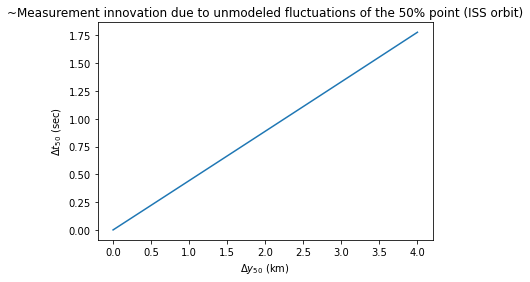

In [42]:
dy_list = np.linspace(0, 4, 100)
dt_list = []
for dy in dy_list:
    y50_predict = c+dy
    dt_list.append(time_vs_y(c+dy)-time_vs_y(c))
    
plt.plot(dy_list, dt_list)
plt.xlabel(r"$\Delta y_{50}$ (km)")
plt.ylabel(r"$\Delta t_{50}$ (sec)")
plt.title("~Measurement innovation due to unmodeled fluctuations of the 50% point (ISS orbit)")
# plt.savefig("/Users/nathanielruhl/Desktop/unmodeled_error.png", dpi=300)
# For example, an unmodeled fluctuation of 0.5 km in 50% altitude causes 0.25 seconds of measurement uncertainty

Text(0.5, 0, 'Tangent Altitude (km)')

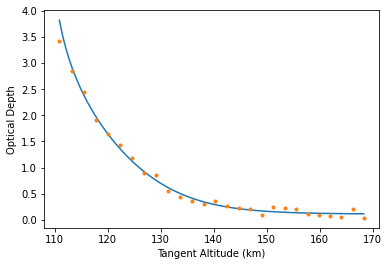

In [12]:
transmit_model = transmit_vs_y(y, *popt)
Gamma_model = -np.log(transmit_model)
# log argument can't be negative, which means we need to be careful near the bottom of the transmittance curve
# The fit definitely is worse and worse near the bottom

plt.plot(y-R_planet, Gamma_model)
plt.plot(y_measured-R_planet, Gamma_measured,'.')
plt.ylabel("Optical Depth")
plt.xlabel("Tangent Altitude (km)")

Re-construction of the fit on the time axis

Text(0.5, 0, 'Time (sec)')

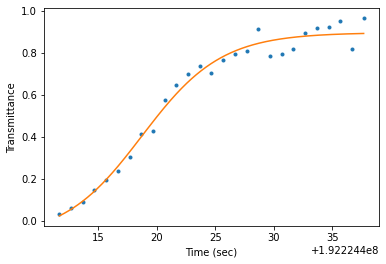

In [16]:
time_measured = time_data[w1:w2]
plt.plot(time_measured, transmit_measured, ".")
plt.plot(time_vs_y(y), transmit_model)
plt.ylabel("Transmittance")
plt.xlabel("Time (sec)")

Invert the Abel integral

In [17]:
# With the substitution y=z/(1-z)+r, we can integrate y=[r,oo] via z=[0,1]
def integrand(z, r):
    return a*b/(np.pi*(1 - z**2)*np.sqrt(-r**2 + (r + z/(1 - z))**2)*(a*np.sinh(b*(-c + r + z/(1 - z))) + d*np.cosh(b*(-c + r + z/(1 - z)))))

In [18]:
from gaussxw import gaussxwab
from scipy.integrate import quad

# Calculate sample points and weights
N=50
z, w = gaussxwab(N,0.0,1.0)
gamma_measured = np.zeros_like(y_measured)   # pseudo-density
for indx, r in enumerate(y_measured):
    s=0.0
    for k in range(N):
        s+=w[k]*integrand(z[k], r)
    gamma_measured[indx] = s

In [19]:
sigma = 600 # 1194  # [cm^2/g] at 1.5 keV

# Can we recover msis mass density?
from pymsis import msis
import datetime
import numbers

# This function gets msis density profile directly from pymsis
def get_pymsis_density(datetime, lon, lat, f107, ap, version, alts=np.arange(y_measured[0]-R_planet, y_measured[-1]-R_planet, 1.0)):
    f107a = f107
    aps = [[ap] * 7]
    output = msis.run(datetime, lon, lat, list(alts), f107, f107a, aps, version=version)

    densities = output[0, 0, 0, :, 0]  # kg/m^3
    densities = densities / 1000  # g/cm^3
    return alts, densities

# This function converts seconds from Jan 1 2014 into a datetime in UTC
def convert_time_NICER(time):
    timezero = datetime.datetime(year=2014, month=1,
                                 day=1, hour=0, minute=0, second=0)
    if isinstance(time, numbers.Real):
        new_time = timezero+datetime.timedelta(seconds=time)
        return new_time
    elif isinstance(time, list) or isinstance(time, np.ndarray):
        new_time_list = []
        for index, t in enumerate(time):
            new_time = timezero + datetime.timedelta(seconds=t)
            new_time_list.append(new_time)
        return np.array(new_time_list)
    else:
        raise RuntimeError('time must be MET number or array/list of times')

In [20]:
alts, rho = get_pymsis_density(convert_time_NICER(240165000.0), 168.7, -43.9, 75.2, 2, version=2)
n = rho*sigma   # convert to pseudo-density 'gamma' [1/cm]

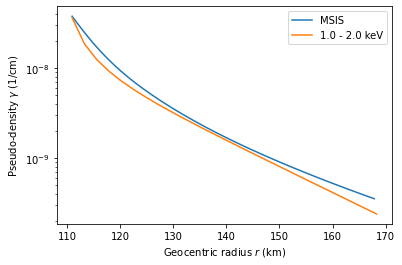

In [21]:
range_i = np.where(gamma_measured>0)[0]
plt.plot(alts, n, label="MSIS")
plt.plot(y_measured[range_i]-R_planet, gamma_measured[range_i]*10**(-5.), label="1.0 - 2.0 keV")
#plt.xlim([100, 200])
plt.ylabel(r"Pseudo-density $\gamma$ (1/cm)")
plt.xlabel(r"Geocentric radius $r$ (km)")
plt.yscale('log')
plt.legend()
plt.savefig('/Users/nathanielruhl/Desktop/pseudo-density-retrieval.png', dpi=300)

In [22]:
# Plot the fractional difference of the above profiles

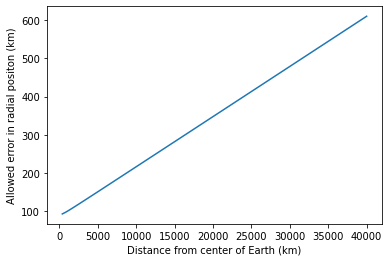

In [23]:
# Sensitivity analysis for the circular orbit

G = 6.6743*10**(-11)     # Nm^2/kg^2, Gravitational constant
M_EARTH = 5.972 * 10 ** 24   # kg, known mass of Earth
R_EARTH = 6378

# Converts orbital radius to period
def a_to_period(a_km):
    a_m = a_km * 10 ** 3   # convert a to meters
    T = np.sqrt((4 * np.pi ** 2 * a_m ** 3) /
                (G * M_EARTH))   # sec
    return T

# Time at h50=100 km
def t50(R_orb, h50=100):
    T = a_to_period(R_orb)
    omega = 2*np.pi/T
    theta=np.arcsin(R_EARTH/R_orb)
    t50 = (np.arcsin((R_EARTH+h50)/R_orb)-theta)/omega
    return t50

# Measurement error resulting from an error in the 50% point
def dt(dh50, R_orb):
    T = a_to_period(R_orb)
    omega = 2*np.pi/T
    theta=np.arcsin(R_EARTH/R_orb)
    return dh50/(R_orb*omega*np.sin(theta+t50(R_orb)*omega))

# error in orbital radius corresponding to a specififed 50% point error, dh50
def dR_orb(H, dh50=85):
    R_orb = R_EARTH+H
    T = a_to_period(R_orb)
    omega = 2*np.pi/T
    theta = np.arcsin(R_EARTH/R_orb)
    return dh50/(np.sin(theta+omega*t50(R_orb))*(1-omega*t50(R_orb)))

H_list = np.linspace(400, 40000, 100)
plt.plot(H_list, dR_orb(H_list))
plt.ylabel("Allowed error in radial positon (km)")
plt.xlabel("Distance from center of Earth (km)")
# print(f"For H=420 km, dR_allowed = {dR_orb(420)}")
plt.savefig("/Users/nathanielruhl/Desktop/allowed_error.png")

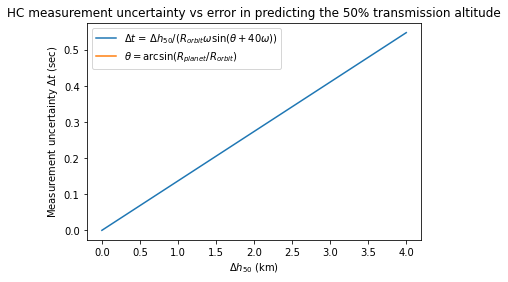

In [24]:
# For the ISS orbit at H = 420 km : dt vs dh50
dh = np.linspace(0, 4, 100)
plt.plot(dh, dt(dh, R_EARTH+420), label=r"$\Delta t$ = $\Delta h_{50}$/($R_{orbit} \omega \sin(\theta+40 \omega)$)")
plt.plot([],[],label=r"$\theta=\arcsin(R_{planet}/R_{orbit})$")
plt.xlabel(r"$\Delta h_{{50}}$ (km)")
plt.ylabel(r"Measurement uncertainty $\Delta t$ (sec)")
plt.title("HC measurement uncertainty vs error in predicting the 50% transmission altitude")
plt.legend()

This plot shows how an error in the 50% transmission point maps to a measurement error for a circular orbit

### Propogation of error for y based on the covarience matrix of the 4 parameters. This math is applied in the code above

In [25]:
import sympy as sp

T, y, a, b, c, d = sp.symbols("T y a b c d")
T = 0.5
y = (1/b)*sp.atanh((T-d)/a)+c

params = [a, b, c, d]
partials = []  # derivative of i wrt params
for xi in params:
    partials.append(sp.diff(y, xi))

In [26]:
partials

[-(0.5 - d)/(a**2*b*(1 - (0.5 - d)**2/a**2)),
 -atanh((0.5 - d)/a)/b**2,
 1,
 -1/(a*b*(1 - (0.5 - d)**2/a**2))]

## Better method to determine comp_range

In [ ]:
# Trying to find a good algorithm to define the comparison window directly from this data
transmit_measured = np.array([1.02126476e+00, 9.75148903e-01, 9.90371613e-01, 1.02126476e+00,
 9.81864805e-01, 1.00425114e+00, 1.00022160e+00, 1.00380342e+00,
 9.85894346e-01, 9.91267067e-01, 9.86789799e-01, 9.70223909e-01,
 9.85894346e-01, 1.02081703e+00, 9.95296608e-01, 9.99773875e-01,
 1.01723522e+00, 1.00246024e+00, 1.02260794e+00, 1.01499659e+00,
 9.93505701e-01, 9.95296608e-01, 1.00514660e+00, 9.71567089e-01,
 9.79626171e-01, 1.00559432e+00, 1.02171249e+00, 9.86342072e-01,
 9.86342072e-01, 9.40226215e-01, 9.82760258e-01, 1.01454886e+00,
 1.01902613e+00, 1.04409883e+00, 1.02574203e+00, 1.03066702e+00,
 9.80969351e-01, 1.02305567e+00, 9.76492083e-01, 1.00425114e+00,
 9.95744334e-01, 9.63508007e-01, 1.00738523e+00, 1.01813067e+00,
 1.01275795e+00, 1.01454886e+00, 9.86789799e-01, 1.00604205e+00,
 9.58583013e-01, 9.90819340e-01, 9.77387537e-01, 9.89923886e-01,
 9.80521624e-01, 1.00156478e+00, 9.86789799e-01, 9.61717100e-01,
 1.04275565e+00, 9.84551165e-01, 9.98430695e-01, 1.02395112e+00,
 1.03424884e+00, 9.99326149e-01, 9.57239832e-01, 1.01007159e+00,
 1.00111706e+00, 1.00559432e+00, 1.01947385e+00, 1.01051932e+00,
 9.80521624e-01, 1.00201251e+00, 1.00335569e+00, 9.92162520e-01,
 9.78282990e-01, 1.00111706e+00, 1.00425114e+00, 9.97982968e-01,
 9.79178444e-01, 1.00783296e+00, 9.99773875e-01, 1.01320568e+00,
 1.00872841e+00, 1.01186250e+00, 9.65746641e-01, 9.64851187e-01,
 1.00917614e+00, 1.00246024e+00, 1.00066933e+00, 1.01499659e+00,
 1.02260794e+00, 1.03111475e+00, 1.01499659e+00, 9.64403461e-01,
 9.84551165e-01, 1.01768295e+00, 1.00514660e+00, 9.97535242e-01,
 9.96639788e-01, 9.74701176e-01, 1.00022160e+00, 9.80073898e-01,
 9.95744334e-01, 1.01947385e+00, 9.93953427e-01, 9.96639788e-01,
 9.97535242e-01, 9.86789799e-01, 9.60373920e-01, 9.84998892e-01,
 1.00604205e+00, 1.01096704e+00, 9.94848881e-01, 1.01275795e+00,
 1.03872610e+00, 9.39778488e-01, 9.79178444e-01, 9.67985275e-01,
 1.02036931e+00, 1.00156478e+00, 9.96192061e-01, 1.01007159e+00,
 9.99773875e-01, 1.00828068e+00, 1.01454886e+00, 1.03469656e+00,
 1.04006928e+00, 9.94848881e-01, 9.72014816e-01, 9.83655712e-01,
 9.93953427e-01, 9.97982968e-01, 9.99773875e-01, 1.03917383e+00,
 1.01141477e+00, 9.63955734e-01, 1.00917614e+00, 9.93953427e-01,
 9.59926193e-01, 9.78282990e-01, 9.50523931e-01, 9.79626171e-01,
 9.64403461e-01, 1.01365341e+00, 9.73357996e-01, 9.87237526e-01,
 1.00246024e+00, 1.00648978e+00, 1.03021930e+00, 9.88580706e-01,
 9.61269373e-01, 9.65746641e-01, 1.00604205e+00, 9.83655712e-01,
 1.00246024e+00, 9.44255756e-01, 9.66194368e-01, 9.67089821e-01,
 1.00246024e+00, 9.72910269e-01, 1.00156478e+00, 9.89923886e-01,
 1.03290566e+00, 9.80969351e-01, 9.33958040e-01, 9.55896652e-01,
 9.43808029e-01, 9.46494390e-01, 9.22764871e-01, 8.96796718e-01,
 8.99483079e-01, 8.44412686e-01, 7.82626392e-01, 7.40987803e-01,
 6.60844711e-01, 5.57867554e-01, 4.73247195e-01, 3.38481437e-01,
 2.11774762e-01, 8.82021735e-02, 1.96999778e-02, 1.02977157e-02,
 6.71590154e-03, 5.82044800e-03, 2.23863385e-03, 3.58181415e-03,
 2.68636061e-03, 4.47726769e-03, 3.13408738e-03, 1.34318031e-03,
 3.13408738e-03, 1.79090708e-03, 4.47726769e-04, 1.34318031e-03,
 4.47726769e-04, 1.79090708e-03, 8.95453538e-04, 1.79090708e-03,
 8.95453538e-04, 1.34318031e-03, 8.95453538e-04, 8.95453538e-04])

In [ ]:
plt.plot(transmit_measured, ".")

In [ ]:
def get_comp_range(transmit_measured):
    comp_range = np.where((transmit_measured < 0.99)&(transmit_measured>0.01))[0]  # initial comp_range
    # Only get the range with the most consecutive ascending/descending values
    num_dict = {}   # starting values are keys, number of sequential elements that follow are columns
    for start_indx in range(len(comp_range)-1):
        i = start_indx + 1
        while (comp_range[start_indx] + (i-start_indx) == comp_range[i])&(i<len(comp_range)-1):
            i += 1
        num_dict[comp_range[start_indx]] = i-start_indx

    import operator
    sorted_tuples = sorted(num_dict.items(), key=operator.itemgetter(1))
    sorted_dict = {v: k for k, v in sorted_tuples} # keys are the number of consecutive entries
    max_consec = max(list(num_dict.values()))  
    comp_range_better = sorted_dict[max_consec] + np.arange(0, max_consec+1, 1)
    return comp_range_better

In [ ]:
rising = np.flip(transmit_measured)
comp_range = get_comp_range(rising)

In [ ]:
plt.plot(rising[comp_range])

The above function works for both rising and setting crossings!!